In [ ]:
#Install necessary packages if not already available in the Colab environment
!apt-get install -y -qq glpk-utils
!which glpsol

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

**Import** **required** **libraries**

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from google.colab import files

**Create the optimization model**

In [ ]:
def create_optw_model(cities, interest, cost, time_matrix, budget, cost_pass, insur_cost, total_days, max_travel_days, lambda_, alpha, max_days_per_city):
    num_cities = len(cities)
    model = ConcreteModel()
    model.Cities = RangeSet(1, num_cities)

    # Decision variables
    model.y = Var(model.Cities, model.Cities, within=Binary)         # travel arc from city i to city j
    model.x = Var(model.Cities, within=NonNegativeIntegers)          # number of days in city i
    model.z = Var(model.Cities, within=Binary)                       # 1 if city i is visited
    model.g = Var(within=NonNegativeIntegers)                        # total travel days
    model.u = Var(model.Cities, within=NonNegativeReals, bounds=(0, num_cities - 1))  # MTZ subtour elimination

    # Objective: maximize utility of stay, reward for visiting more cities, penalty for travel time
    model.obj = Objective(
        expr=sum(interest[i-1] * model.x[i] for i in model.Cities)
           + alpha * sum(model.z[i] for i in model.Cities)
           - lambda_ * sum(time_matrix[i-1][j-1] * model.y[i, j]
                           for i in model.Cities for j in model.Cities if i != j),
        sense=maximize
    )

    # Constraints
    model.total_days = Constraint(expr=sum(model.x[i] for i in model.Cities) + model.g <= total_days)
    model.travel_days = Constraint(expr=model.g <= max_travel_days)
    model.budget_limit = Constraint(expr=sum(cost[i-1] * model.x[i] for i in model.Cities) + cost_pass + insur_cost <= budget)

    # Visiting constraints
    model.visiting = ConstraintList()
    for i in model.Cities:
        model.visiting.add(model.x[i] <= 30 * model.z[i])
        model.visiting.add(model.x[i] >= model.z[i])
        model.visiting.add(model.x[i] <= model.z[i] * max_days_per_city)

    # Flow conservation constraints
    model.flow = ConstraintList()
    for i in model.Cities:
        model.flow.add(sum(model.y[i, j] for j in model.Cities if j != i) == model.z[i])
        model.flow.add(sum(model.y[j, i] for j in model.Cities if j != i) == model.z[i])
        model.flow.add(model.y[i, i] == 0)

    # Start and end in Milan (city 1)
    model.departure = Constraint(expr=sum(model.y[1, j] for j in model.Cities if j != 1) == 1)
    model.return_trip = Constraint(expr=sum(model.y[j, 1] for j in model.Cities if j != 1) == 1)

    # Number of arcs equals number of travel days
    model.routes = Constraint(expr=sum(model.y[i, j] for i in model.Cities for j in model.Cities) == model.g)

    # Subtour elimination using Miller-Tucker-Zemlin (MTZ) constraints
    model.subtour_constraints = ConstraintList()
    model.subtour_constraints.add(model.u[1] == 0)
    for i in model.Cities:
        for j in model.Cities:
            if i != j and i != 1 and j != 1:
                model.subtour_constraints.add(
                    model.u[i] + 1 <= model.u[j] + (num_cities - 1) * (1 - model.y[i, j])
                )

    # Link between routes and visits
    model.y_z_link = ConstraintList()
    for i in model.Cities:
        for j in model.Cities:
            if i != j:
                model.y_z_link.add(model.y[i, j] <= model.z[i])
                model.y_z_link.add(model.y[i, j] <= model.z[j])

    return model

**Upload the Excel file**

In [ ]:
uploaded = files.upload()

Saving data_optimization_project.xlsx to data_optimization_project.xlsx


In [ ]:
df = pd.read_excel('interrail_data.xlsx')
print(df.head())

   Nodes     city  interest  cost
0      0    Milan      4.61   155
1      1   Lisbon      4.37   130
2      2    Porto      4.52   100
3      3     Faro      4.19   120
4      4  Coimbra      4.50   110


In [ ]:
def get_data_from_excel(file_name):
    data1 = pd.read_excel(file_name, sheet_name="data")
    cities = data1["city"].tolist()
    interest = data1["interest"].tolist()
    cost = data1["cost"].tolist()

    data2 = pd.read_excel(file_name, sheet_name="time_matrix", index_col=0)
    time_matrix = data2.loc[cities, cities].values

    return cities, interest, cost, time_matrix

**Parameters**

In [ ]:
cost_pass = 286
insur_cost = 55
budget = 2500
total_days = 30
max_travel_days = 7
lambda_ = 0.02
alpha = 3
file_name = "interrail_data.xlsx"  # Make sure this matches the uploaded filename
max_days_per_city = 5

**Load** **data**

In [ ]:
cities, interest, cost, time_matrix = get_data_from_excel(file_name)
print("Cities:", cities)
print("Interest:", interest)
print("Cost per day:", cost)
print("Time matrix shape:", time_matrix.shape)

Cities: ['Milan', 'Lisbon', 'Porto', 'Faro', 'Coimbra', 'Fatima', 'Madrid', 'Barcelona', 'Zaragozza', 'Valencia', 'Seville', 'Venice', 'Rome', 'Florence', 'Naples', 'Paris', 'Lyon', 'Nice', 'Bordeaux', 'Toulouse']
Interest: [4.61, 4.37, 4.52, 4.19, 4.5, 4.59, 4.6, 4.55, 4.56, 4.46, 4.7, 4.58, 4.56, 4.59, 4.68, 4.62, 4.58, 4.53, 4.35, 4.29]
Cost per day: [155, 130, 100, 120, 110, 100, 130, 150, 100, 110, 110, 155, 145, 135, 110, 155, 110, 130, 110, 100]
Time matrix shape: (20, 20)


**Create and solve the model**

In [ ]:
model = create_optw_model(cities, interest, cost, time_matrix, budget, cost_pass, insur_cost, total_days, max_travel_days, lambda_, alpha, max_days_per_city)
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
results = solver.solve(model, tee=True, timelimit=600)

# Extract and organize solution
solution = []
for i in model.Cities:
    for j in model.Cities:
        if i != j and pyo.value(model.y[i, j]) > 0.5:
            solution.append((cities[i-1], cities[j-1]))

# Reorder the travel path
def reorder_path(solution, node_list):
    start = node_list[0]
    end = node_list[0]
    current = start
    ordered_arcs = []
    ordered_nodes = []

    while current != end or not ordered_nodes:
        ordered_nodes.append(current)
        found = False
        for arc in solution:
            if arc[0] == current:
                ordered_arcs.append(arc)
                current = arc[1]
                found = True
                break
        if not found:
            break  # Avoid infinite loop

    ordered_nodes.append(end)
    return ordered_arcs, ordered_nodes

ordered_arcs, ordered_cities = reorder_path(solution, cities)

# Print results
print(f"Objective value: {pyo.value(model.obj):.2f}")
print("\n--- Sequence of visited cities and days of stay ---")
for city in ordered_cities[:-1]:  # Skip repeated last city
    idx = cities.index(city) + 1  # Pyomo indexing starts at 1
    days = round(pyo.value(model.x[idx]))
    print(f"{city} ({days} day{'s' if days > 1 else ''})")

print("\n--- Ordered travel arcs ---")
for arc in ordered_arcs:
    print(f"{arc[0]} → {arc[1]}")

print("\n--- Full travel sequence ---")
print(" → ".join(ordered_cities))

print(f"\nTotal travel days: {sum(model.x[i].value for i in model.Cities) + model.g.value:.1f}")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --write /tmp/tmpqhz0hdii.glpk.raw --wglp /tmp/tmpz7zzf945.glpk.glp
 --cpxlp /tmp/tmph6moffag.pyomo.lp
Reading problem data from '/tmp/tmph6moffag.pyomo.lp'...
/tmp/tmph6moffag.pyomo.lp:8568: warning: lower bound of variable 'x22' redefined
/tmp/tmph6moffag.pyomo.lp:8568: warning: upper bound of variable 'x22' redefined
1229 rows, 461 columns, 3968 non-zeros
441 integer variables, 420 of which are binary
8988 lines were read
Writing problem data to '/tmp/tmpz7zzf945.glpk.glp'...
7289 lines were written
GLPK Integer Optimizer 5.0
1229 rows, 461 columns, 3968 non-zeros
441 integer variables, 420 of which are binary
Preprocessing...
20 constraint coefficient(s) were reduced
1207 rows, 440 columns, 3926 non-zeros
421 integer variables, 400 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.550e+02  ratio =  1.550e+02
GM: min|aij| =  6.687e-01  max|aij| =  1.495e+00  ratio =  2.236e+0

**Plot of the interrail route**

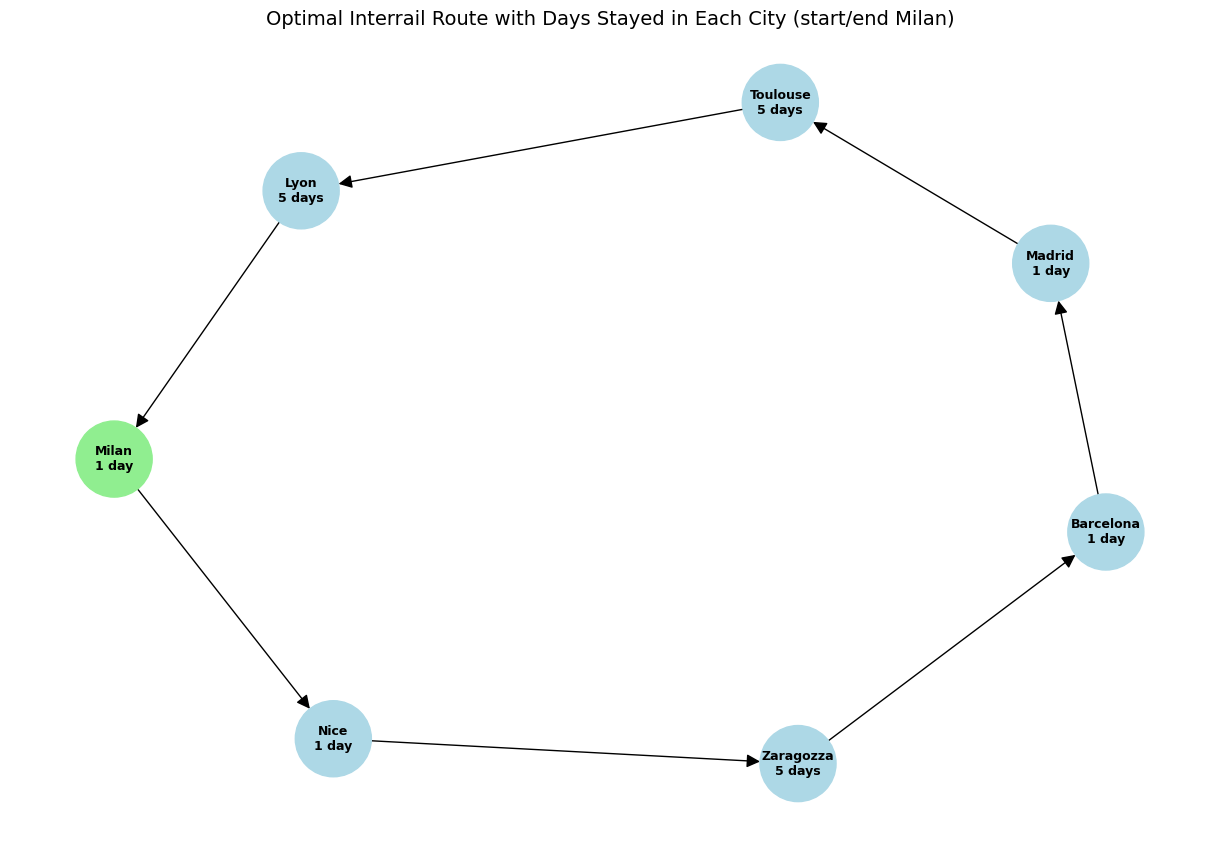

In [ ]:
def plot_interrail_graph_with_milan_and_days(model, cities):
    graph = nx.DiGraph()
    edges = []

    starting_city = cities[0]
    days_stay = {}

    for i in model.Cities:
        days_stay[cities[i - 1]] = round(pyo.value(model.x[i]))

    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) == 1:
                city_i = cities[i - 1]
                city_j = cities[j - 1]
                graph.add_edge(city_i, city_j)
                edges.append((city_i, city_j))

    positions = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 8))
    node_colors = ['lightgreen' if city == starting_city else 'lightblue' for city in graph.nodes()]

    # Create labels with city name and days stayed
    labels = {city: f"{city}\n{days_stay[city]} day{'s' if days_stay[city] != 1 else ''}" for city in graph.nodes()}

    nx.draw(graph, positions, with_labels=False, node_size=3000, node_color=node_colors,
            font_size=10, font_weight='bold', arrows=True, arrowsize=20)

    # Draw labels manually to customize multiline text
    nx.draw_networkx_labels(graph, positions, labels=labels, font_size=9, font_weight='bold')

    plt.title("Optimal Interrail Route with Days Stayed in Each City (start/end Milan)", fontsize=14)
    plt.axis('off')
    plt.show()

    return edges

# Final plot with days shown
edges = plot_interrail_graph_with_milan_and_days(model, cities)

# **Sensitivity analysis on budget**

**Plot**

In [ ]:
def plot_interrail_graph_with_milan_and_days(model, cities, current_budget):
    graph = nx.DiGraph()
    edges = []

    starting_city = cities[0]
    days_stay = {}

    for i in model.Cities:
        days_stay[cities[i - 1]] = round(pyo.value(model.x[i]))

    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) == 1:
                city_i = cities[i - 1]
                city_j = cities[j - 1]
                graph.add_edge(city_i, city_j)
                edges.append((city_i, city_j))

    positions = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 8))
    node_colors = ['lightgreen' if city == starting_city else 'lightblue' for city in graph.nodes()]

    labels = {city: f"{city}\n{days_stay[city]} day{'s' if days_stay[city] != 1 else ''}" for city in graph.nodes()}

    nx.draw(graph, positions, with_labels=False, node_size=3000, node_color=node_colors,
            font_size=10, font_weight='bold', arrows=True, arrowsize=20)

    nx.draw_networkx_labels(graph, positions, labels=labels, font_size=9, font_weight='bold')

    plt.title(f"Optimal Interrail Route with Days Stayed (Budget = {budget})", fontsize=14)
    plt.axis('off')
    plt.show()

    return edges


--- Solving model with budget = 2000 ---
Objective value: 55.58
Visited cities and days of stay:
  Milan: 3 days
  Florence: 5 days
  Rome: 1 day
  Naples: 3 days
Travel sequence:
Milan → Florence → Rome → Naples → Milan

Total travel days: 16.0


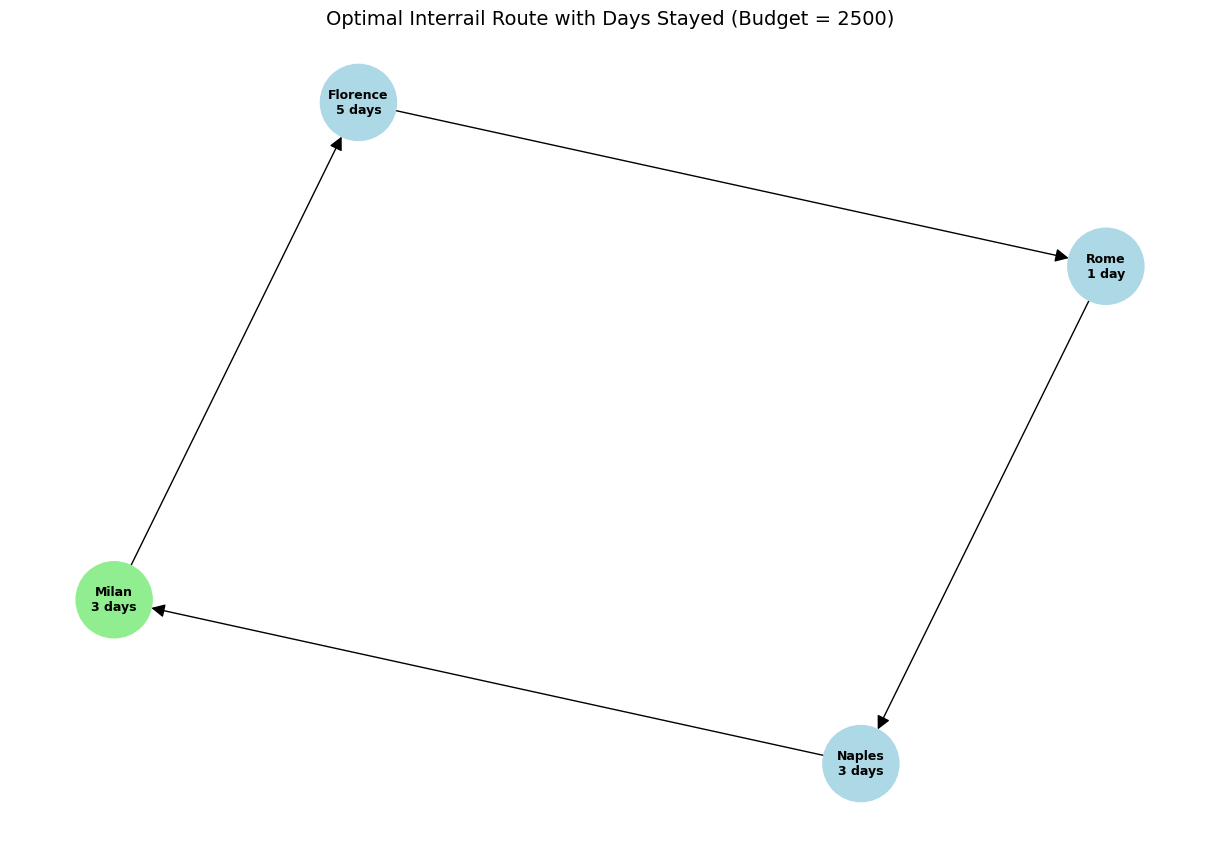


--- Solving model with budget = 2500 ---
Objective value: 62.98
Visited cities and days of stay:
  Milan: 1 day
  Nice: 1 day
  Zaragozza: 5 days
  Barcelona: 1 day
  Madrid: 1 day
  Toulouse: 5 days
  Lyon: 5 days
Travel sequence:
Milan → Nice → Zaragozza → Barcelona → Madrid → Toulouse → Lyon → Milan

Total travel days: 26.0


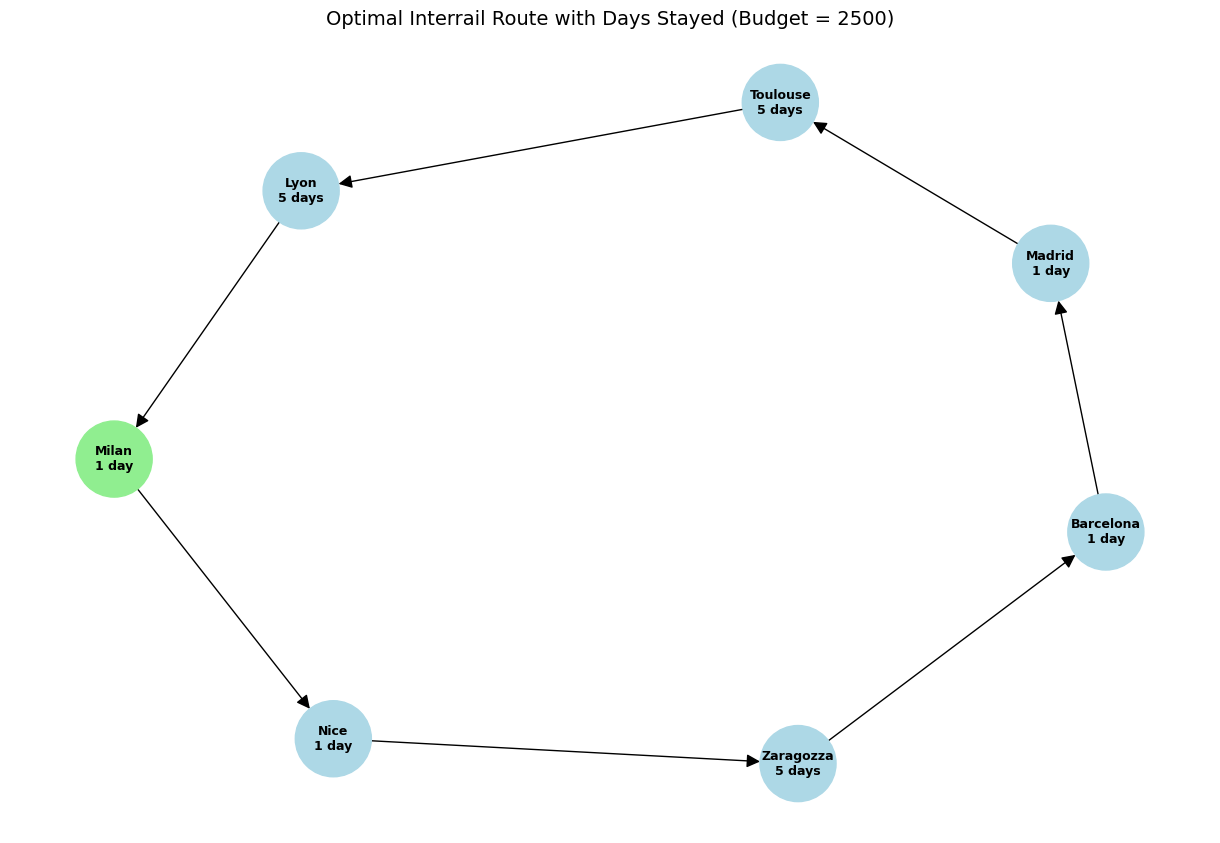


--- Solving model with budget = 3000 ---
Objective value: 82.66
Visited cities and days of stay:
  Milan: 1 day
  Nice: 5 days
  Lyon: 5 days
  Rome: 1 day
  Naples: 5 days
  Florence: 4 days
Travel sequence:
Milan → Nice → Lyon → Rome → Naples → Florence → Milan

Total travel days: 27.0


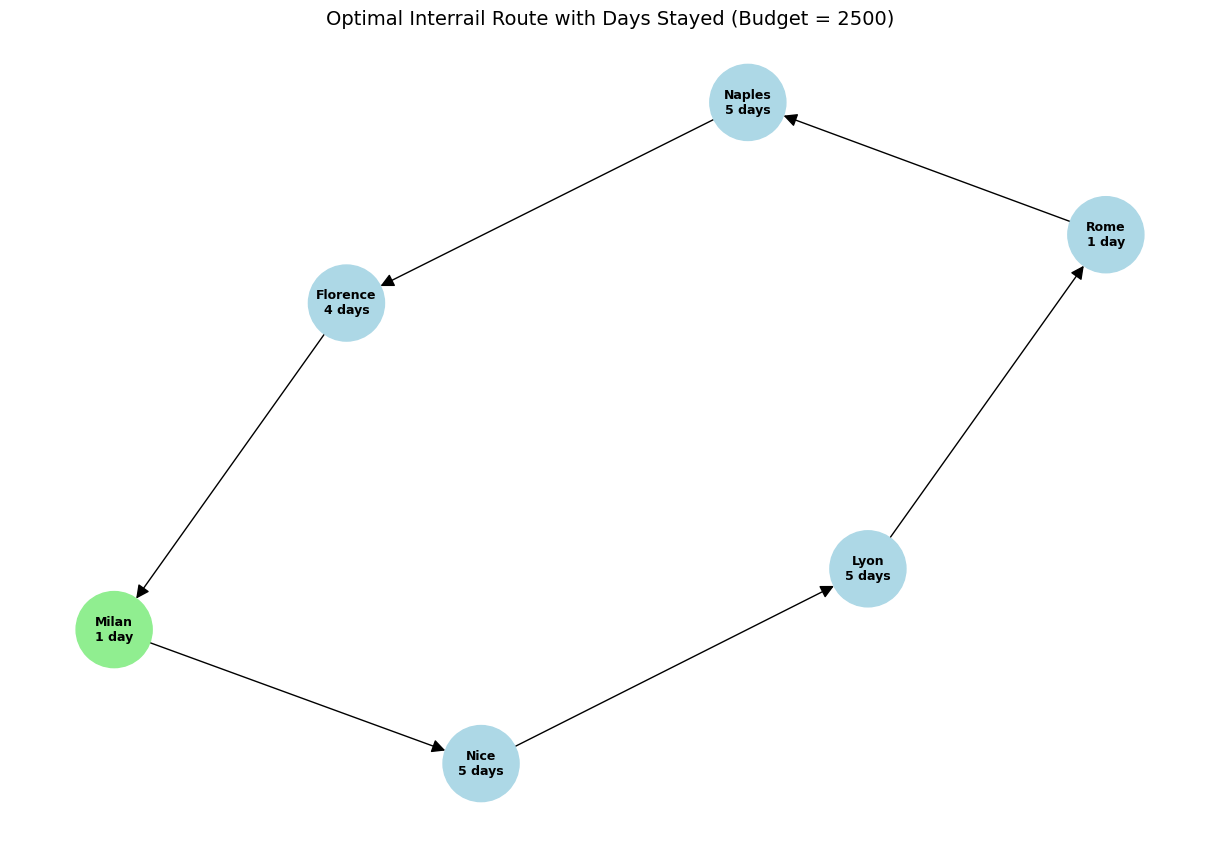

In [ ]:
# Define a list of budget values to test
budget_values = [2000, 2500, 3000]

# Dictionary to store results keyed by budget
results_by_budget = {}
objective_values = []

for current_budget in budget_values:
    print(f"\n--- Solving model with budget = {current_budget} ---")

    # Create a new model instance with the current budget
    model = create_optw_model(cities, interest, cost, time_matrix,
                             current_budget, cost_pass, insur_cost, total_days,
                             max_travel_days, lambda_, alpha, max_days_per_city)

    # Solve the model
    solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
    results = solver.solve(model, tee=False, timelimit=60)

    # Extract solution
    solution = []
    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) > 0.5:
                solution.append((cities[i-1], cities[j-1]))

    ordered_arcs, ordered_cities = reorder_path(solution, cities)

    # Collect results
    city_days = {}
    for city in ordered_cities[:-1]:  # skip last repeated city
        idx = cities.index(city) + 1
        city_days[city] = round(pyo.value(model.x[idx]))

    obj_val = pyo.value(model.obj)
    objective_values.append(obj_val)

    results_by_budget[current_budget] = {
        'ordered_cities': ordered_cities,
        'ordered_arcs': ordered_arcs,
        'city_days': city_days,
        'objective_value': pyo.value(model.obj)
    }

    # Print summary
    print(f"Objective value: {results_by_budget[current_budget]['objective_value']:.2f}")
    print("Visited cities and days of stay:")
    for city, days in city_days.items():
        print(f"  {city}: {days} day{'s' if days > 1 else ''}")
    print("Travel sequence:")
    print(" → ".join(ordered_cities))
    print(f"\nTotal travel days: {sum(model.x[i].value for i in model.Cities) + model.g.value:.1f}")


    plot_interrail_graph_with_milan_and_days(model, cities, current_budget)

**Plot trend of objective function value vs budget**

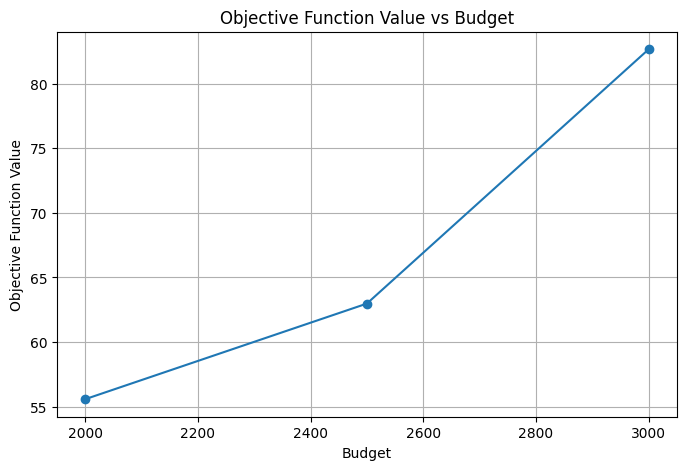

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(budget_values, objective_values, marker='o', linestyle='-')
plt.title('Objective Function Value vs Budget')
plt.xlabel('Budget')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.show()

# **Sensitivity analysis on alpha**

**Plot**

In [ ]:
def plot_interrail_graph_with_milan_and_days(model, cities, alpha):
    graph = nx.DiGraph()
    edges = []

    starting_city = cities[0]
    days_stay = {}

    for i in model.Cities:
        days_stay[cities[i - 1]] = round(pyo.value(model.x[i]))

    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) == 1:
                city_i = cities[i - 1]
                city_j = cities[j - 1]
                graph.add_edge(city_i, city_j)
                edges.append((city_i, city_j))

    positions = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 8))
    node_colors = ['lightgreen' if city == starting_city else 'lightblue' for city in graph.nodes()]

    labels = {city: f"{city}\n{days_stay[city]} day{'s' if days_stay[city] != 1 else ''}" for city in graph.nodes()}

    nx.draw(graph, positions, with_labels=False, node_size=3000, node_color=node_colors,
            font_size=10, font_weight='bold', arrows=True, arrowsize=20)

    nx.draw_networkx_labels(graph, positions, labels=labels, font_size=9, font_weight='bold')

    plt.title(f"Optimal Interrail Route with Days Stayed (Alpha = {alpha})", fontsize=14)
    plt.axis('off')
    plt.show()

    return edges


--- Solving model with alpha = 1 ---
Objective value: 38.12
Visited cities and days of stay:
  Milan: 1 day
  Lyon: 5 days
  Zaragozza: 1 day
  Madrid: 1 day
  Valencia: 5 days
  Toulouse: 1 day
  Nice: 4 days
Travel sequence:
Milan → Lyon → Zaragozza → Madrid → Valencia → Toulouse → Nice → Milan

Total travel days: 25.0


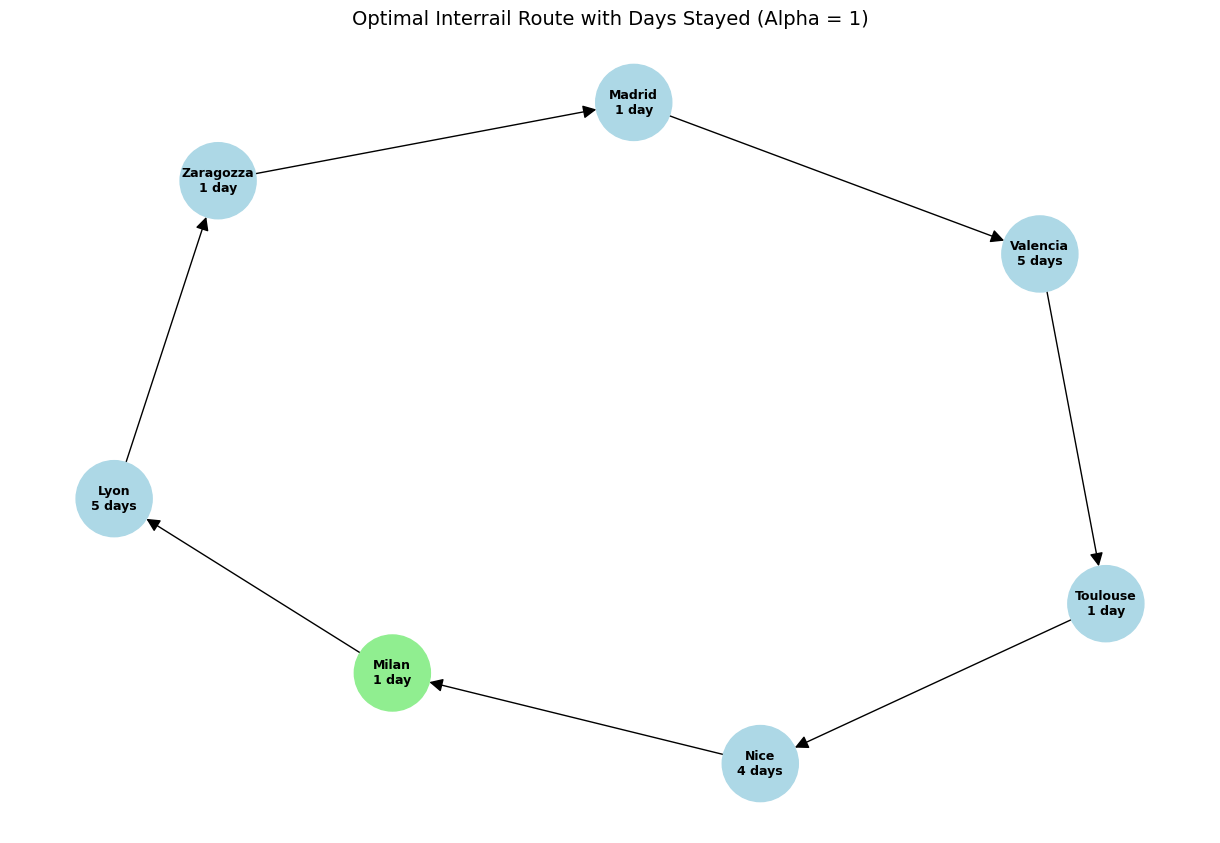


--- Solving model with alpha = 3 ---


KeyboardInterrupt: 

In [ ]:
# List of alpha values to test
alpha_values = [1, 3, 5]

# Dictionary to store results
results_by_alpha = {}
objective_values = []

# Fixed budget
budget = 2500

for current_alpha in alpha_values:
    print(f"\n--- Solving model with alpha = {current_alpha} ---")

    # Create model with current alpha
    model = create_optw_model(cities, interest, cost, time_matrix,
                             budget, cost_pass, insur_cost, total_days,
                             max_travel_days, lambda_, current_alpha, max_days_per_city)

    # Solve the model
    solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
    results = solver.solve(model, tee=False, timelimit=60)

    # Extract solution
    solution = []
    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) > 0.5:
                solution.append((cities[i-1], cities[j-1]))

    ordered_arcs, ordered_cities = reorder_path(solution, cities)

    # Extract number of days stayed in each city
    city_days = {}
    for city in ordered_cities[:-1]:  # Skip last repeated city
        idx = cities.index(city) + 1
        city_days[city] = round(pyo.value(model.x[idx]))

    # Store results
    obj_val = pyo.value(model.obj)
    objective_values.append(obj_val)

    results_by_alpha[current_alpha] = {
        'ordered_cities': ordered_cities,
        'ordered_arcs': ordered_arcs,
        'city_days': city_days,
        'objective_value': obj_val
    }

    # Print summary
    print(f"Objective value: {obj_val:.2f}")
    print("Visited cities and days of stay:")
    for city, days in city_days.items():
        print(f"  {city}: {days} day{'s' if days > 1 else ''}")
    print("Travel sequence:")
    print(" → ".join(ordered_cities))
    print(f"\nTotal travel days: {sum(model.x[i].value for i in model.Cities) + model.g.value:.1f}")

    # Plot graph for current alpha
    plot_interrail_graph_with_milan_and_days(model, cities, current_alpha)

**Plot trend of objective function value vs alpha**

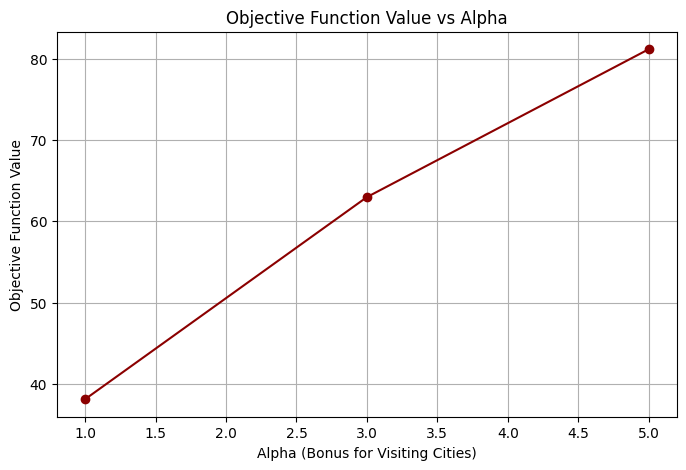

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, objective_values, marker='o', linestyle='-', color='darkred')
plt.title('Objective Function Value vs Alpha')
plt.xlabel('Alpha (Bonus for Visiting Cities)')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.show()

# **Sensitivity analysis on lambda**

**Plot**

In [ ]:
def plot_interrail_graph(model, cities, param_value, param_name="Parameter"):
    graph = nx.DiGraph()
    edges = []

    starting_city = cities[0]
    days_stay = {}

    for i in model.Cities:
        days_stay[cities[i - 1]] = round(pyo.value(model.x[i]))

    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) == 1:
                city_i = cities[i - 1]
                city_j = cities[j - 1]
                graph.add_edge(city_i, city_j)
                edges.append((city_i, city_j))

    positions = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 8))
    node_colors = ['lightgreen' if city == starting_city else 'lightblue' for city in graph.nodes()]

    labels = {city: f"{city}\n{days_stay[city]} day{'s' if days_stay[city] != 1 else ''}" for city in graph.nodes()}

    nx.draw(graph, positions, with_labels=False, node_size=3000, node_color=node_colors,
            font_size=10, font_weight='bold', arrows=True, arrowsize=20)

    nx.draw_networkx_labels(graph, positions, labels=labels, font_size=9, font_weight='bold')

    plt.title(f"Optimal Interrail Route with Days Stayed ({param_name} = {param_value})", fontsize=14)
    plt.axis('off')
    plt.show()

    return edges


--- Solving model with lambda = 0.01 ---
Objective value: 77.54
Visited cities and days of stay:
  Milan: 1 day
  Seville: 5 days
  Valencia: 1 day
  Barcelona: 1 day
  Zaragozza: 5 days
  Madrid: 1 day
  Lyon: 5 days
Travel sequence:
Milan → Seville → Valencia → Barcelona → Zaragozza → Madrid → Lyon → Milan

Total travel days: 26.0


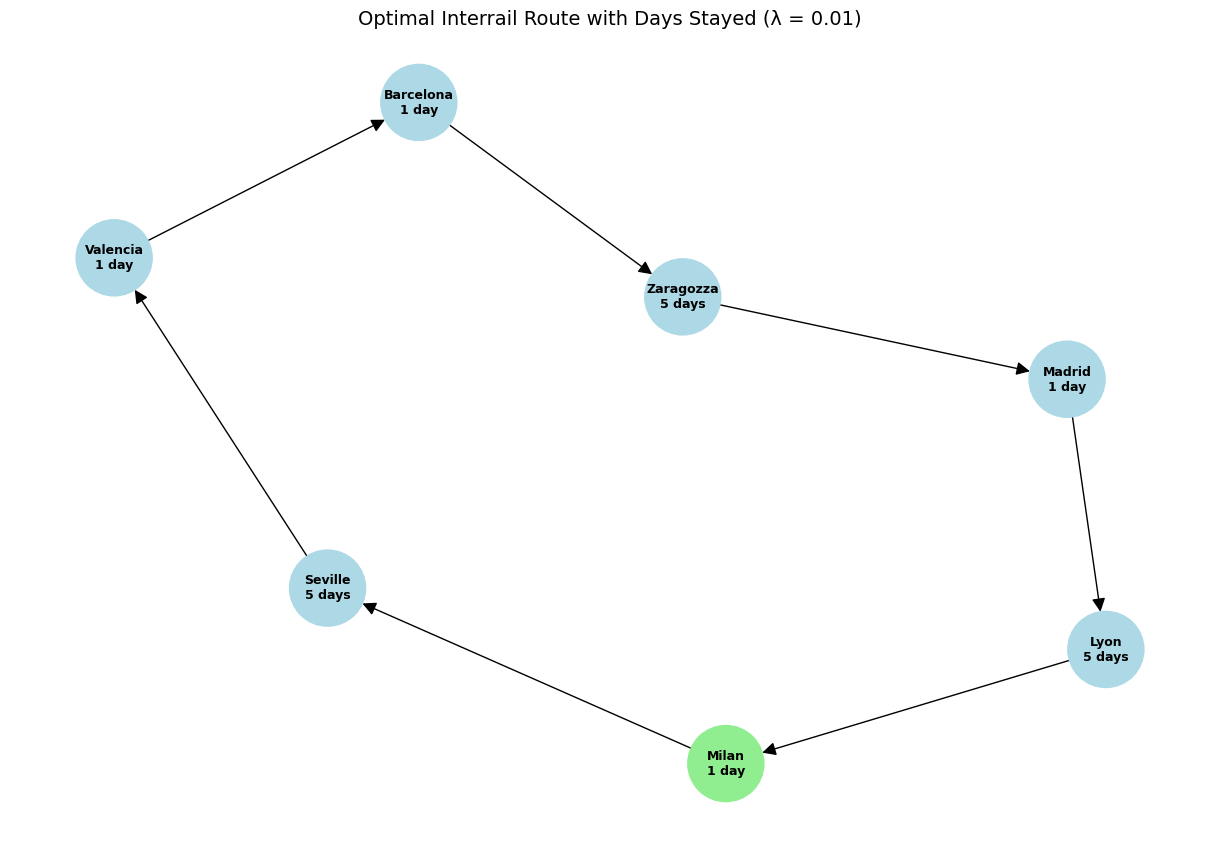


--- Solving model with lambda = 0.02 ---
Objective value: 62.98
Visited cities and days of stay:
  Milan: 1 day
  Nice: 1 day
  Zaragozza: 5 days
  Barcelona: 1 day
  Madrid: 1 day
  Toulouse: 5 days
  Lyon: 5 days
Travel sequence:
Milan → Nice → Zaragozza → Barcelona → Madrid → Toulouse → Lyon → Milan

Total travel days: 26.0


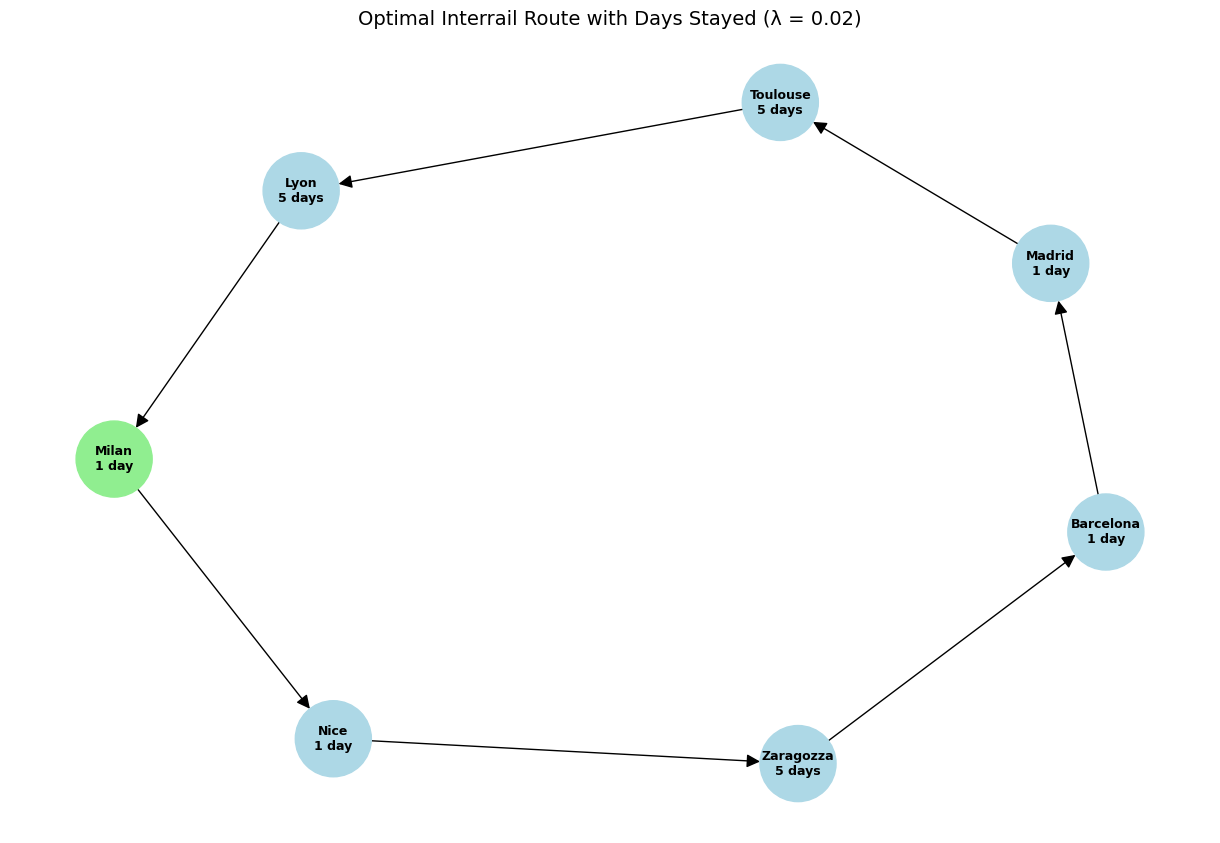


--- Solving model with lambda = 0.05 ---
Objective value: 20.29
Visited cities and days of stay:
  Milan: 2 days
  Florence: 5 days
  Nice: 5 days
  Lyon: 4 days
Travel sequence:
Milan → Florence → Nice → Lyon → Milan

Total travel days: 20.0


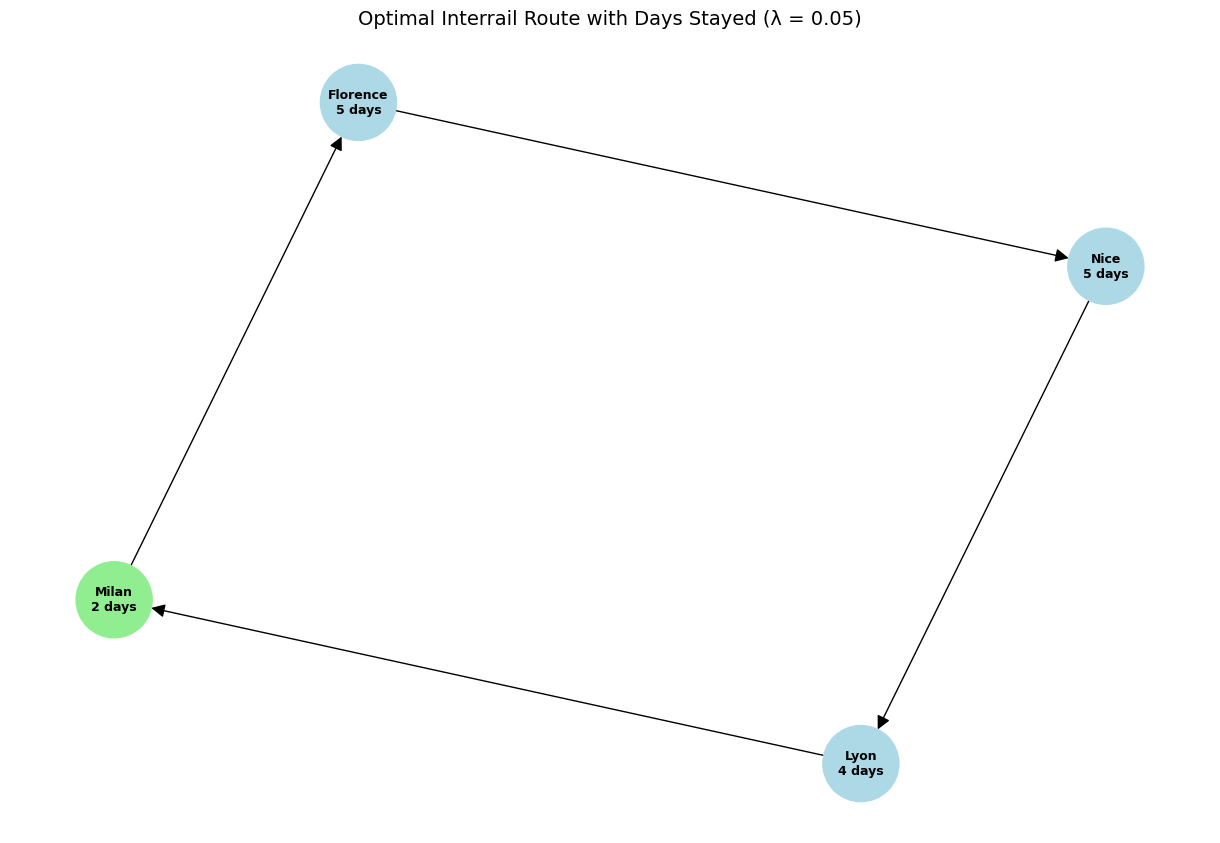

In [ ]:
# Sensitivity analysis for lambda
lambda_values = [0.01, 0.02, 0.05]
objective_values = []
results_by_lambda = {}

# Fixed values
budget = 2500
alpha = 3

for current_lambda in lambda_values:
    print(f"\n--- Solving model with lambda = {current_lambda} ---")

    model = create_optw_model(cities, interest, cost, time_matrix,
                              budget, cost_pass, insur_cost, total_days,
                              max_travel_days, current_lambda, alpha, max_days_per_city)

    solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
    results = solver.solve(model, tee=False, timelimit=60)

    solution = []
    for i in model.Cities:
        for j in model.Cities:
            if i != j and pyo.value(model.y[i, j]) > 0.5:
                solution.append((cities[i-1], cities[j-1]))

    ordered_arcs, ordered_cities = reorder_path(solution, cities)

    city_days = {}
    for city in ordered_cities[:-1]:  # skip last repeated city
        idx = cities.index(city) + 1
        city_days[city] = round(pyo.value(model.x[idx]))

    obj_val = pyo.value(model.obj)
    objective_values.append(obj_val)

    results_by_lambda[current_lambda] = {
        'ordered_cities': ordered_cities,
        'ordered_arcs': ordered_arcs,
        'city_days': city_days,
        'objective_value': obj_val
    }

    print(f"Objective value: {obj_val:.2f}")
    print("Visited cities and days of stay:")
    for city, days in city_days.items():
        print(f"  {city}: {days} day{'s' if days > 1 else ''}")
    print("Travel sequence:")
    print(" → ".join(ordered_cities))
    print(f"\nTotal travel days: {sum(model.x[i].value for i in model.Cities) + model.g.value:.1f}")

    # Graph for current lambda
    plot_interrail_graph(model, cities, current_lambda, param_name="λ")

**Plot trend of objective function value vs lambda**

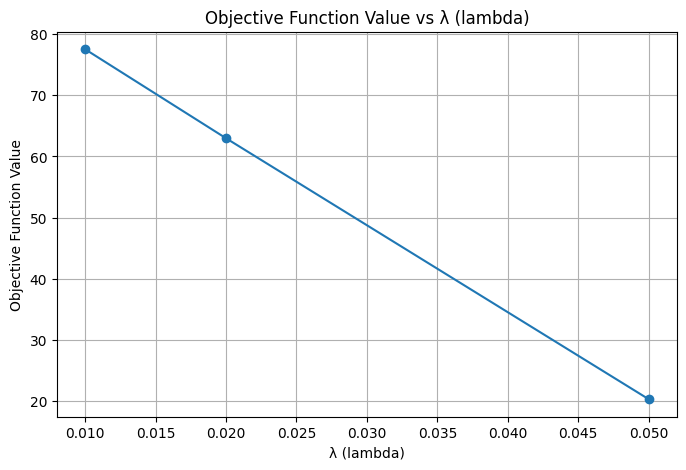

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(lambda_values, objective_values, marker='o', linestyle='-')
plt.title("Objective Function Value vs λ (lambda)")
plt.xlabel("λ (lambda)")
plt.ylabel("Objective Function Value")
plt.grid(True)
plt.show()